# Лабораторная работа №4: "Линейные модели, SVM и деревья решений".

## Загрузка датасета

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import Image
from IPython.core.display import HTML

In [3]:
data = pd.read_csv('cars_price_2_processed.csv')
data.head()

,Unnamed: 0,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price,Location_Ahmedabad,Location_Bangalore,...,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Owner_Type_First,Owner_Type_Fourth & Above,Owner_Type_Second,Owner_Type_Third
0,0,2010,72000,26.60,998,58.16,5.0,1.75,0,0,...,1,0,0,0,0,1,1,0,0,0
1,1,2015,41000,19.67,1582,126.20,5.0,12.50,0,0,...,0,1,0,0,0,1,1,0,0,0
2,2,2011,46000,18.20,1199,88.70,5.0,4.50,0,0,...,0,0,0,1,0,1,1,0,0,0
3,3,2012,87000,20.77,1248,88.76,7.0,6.00,0,0,...,0,1,0,0,0,1,1,0,0,0
4,4,2013,40670,15.20,1968,140.80,5.0,17.74,0,0,...,0,1,0,0,1,0,0,0,1,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 5872 non-null   int64  
 1   Year                       5872 non-null   int64  
 2   Kilometers_Driven          5872 non-null   int64  
 3   Mileage                    5872 non-null   float64
 4   Engine                     5872 non-null   int64  
 5   Power                      5872 non-null   float64
 6   Seats                      5872 non-null   float64
 7   Price                      5872 non-null   float64
 8   Location_Ahmedabad         5872 non-null   int64  
 9   Location_Bangalore         5872 non-null   int64  
 10  Location_Chennai           5872 non-null   int64  
 11  Location_Coimbatore        5872 non-null   int64  
 12  Location_Delhi             5872 non-null   int64  
 13  Location_Hyderabad         5872 non-null   int64

## Корреляционный анализ

In [7]:
print('Признаки, имеющие максимальную по модулю корреляцию с ценой ноутбука')
best_params = data.corr()['Price'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.3]
best_params

Признаки, имеющие максимальную по модулю корреляцию с ценой ноутбука


Power                     0.772843
Engine                    0.658047
Transmission_Automatic    0.585623
Transmission_Manual       0.585623
Mileage                   0.341652
Fuel_Type_Diesel          0.321035
Fuel_Type_Petrol          0.309363
Name: Price, dtype: float64

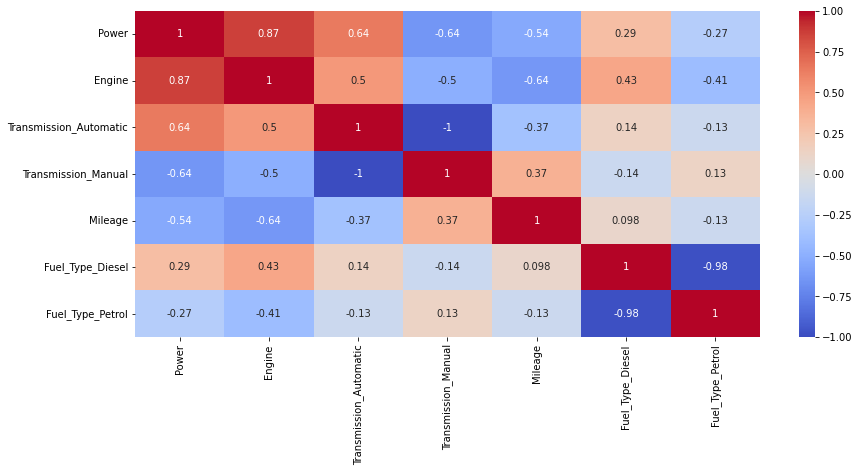

In [8]:
plt.figure(figsize=(14, 6))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

In [9]:
best_params = best_params.drop(['Engine', 'Transmission_Manual', 'Fuel_Type_Petrol'])

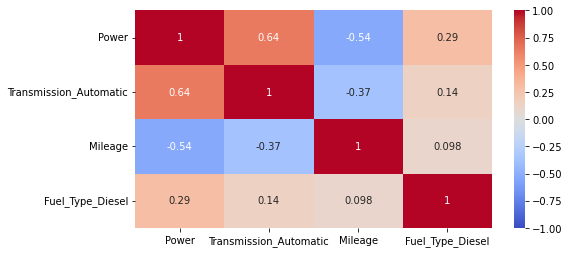

In [10]:
plt.figure(figsize=(8, 4))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

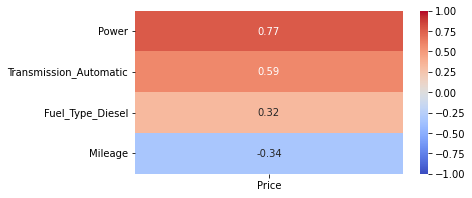

In [12]:
plt.figure(figsize=(6, 3))
sns.heatmap(pd.DataFrame(data[np.append(best_params.index.values, 'Price')].corr()['Price'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

## Разделение выборки на обучающую и тестовую

In [13]:
y = data['Price']
X = data[best_params.index]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

## Линейная регрессия

In [14]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [15]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred_linear = linear_model.predict(x_test)
print_metrics(y_test, y_pred_linear)

R^2: 0.6306198683102151
MSE: 43.12456708118208
MAE: 3.983550649759265


## Пополиномиальная регрессия

In [16]:
poly_model = PolynomialFeatures(degree=3)
x_train_poly = poly_model.fit_transform(x_train)
x_test_poly = poly_model.fit_transform(x_test)
linear_model = LinearRegression()
linear_model.fit(x_train_poly, y_train)
y_pred_poly = linear_model.predict(x_test_poly)
print_metrics(y_test, y_pred_poly)

R^2: 0.697571303238948
MSE: 35.30808915217877
MAE: 3.296718915236735


## SVM

In [17]:
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)
x_train_scaled.describe()

,Power,Transmission_Automatic,Mileage,Fuel_Type_Diesel
count,4.110000e+03,4.110000e+03,4.110000e+03,4.110000e+03
mean,2.005425e-16,6.915258e-17,6.396613e-17,-1.413306e-16
std,1.000122e+00,1.000122e+00,1.000122e+00,1.000122e+00
min,-1.480000e+00,-6.432952e-01,-4.207919e+00,-1.082730e+00
25%,-6.984864e-01,-6.432952e-01,-6.910378e-01,-1.082730e+00
50%,-2.748350e-01,-6.432952e-01,4.747981e-03,9.235912e-01
75%,4.825342e-01,1.554496e+00,6.453309e-01,9.235912e-01
max,8.361215e+00,1.554496e+00,3.506678e+00,9.235912e-01


In [18]:
params = {'C': np.concatenate([np.arange(0.1, 2, 0.1), np.arange(2, 15, 1)])}
svm_model = SVR(kernel='linear')
grid_cv = GridSearchCV(estimator=svm_model, param_grid=params, cv=10, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train_scaled, y_train)
print(grid_cv.best_params_)

{'C': 14.0}


In [19]:
best_svm_model = grid_cv.best_estimator_
best_svm_model = SVR(kernel='linear', C=14)
best_svm_model.fit(x_train_scaled, y_train)
y_pred_svm = best_svm_model.predict(x_test_scaled)
print_metrics(y_test, y_pred_svm)

R^2: 0.6035140496266517
MSE: 46.2891300769292
MAE: 3.7213021301959976


## Дерево решений

In [38]:
params = {'min_samples_leaf': range(3, 30)}
tree = DecisionTreeRegressor(random_state=3)
grid_cv = GridSearchCV(estimator=tree, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'min_samples_leaf': 3}


In [39]:
best_tree = grid_cv.best_estimator_
best_tree.fit(x_train, y_train)
y_pred_tree = best_tree.predict(x_test)
print_metrics(y_test, y_pred_tree)

R^2: 0.691540870508795
MSE: 36.012132977195456
MAE: 2.5113584837999228


In [22]:
importances = pd.DataFrame(data=zip(x_train.columns, best_tree.feature_importances_), columns=['Признак', 'Важность'])
print('Важность признаков в дереве решений\n')
for row in importances.sort_values(by='Важность', ascending=False).values:
    print(f'{row[0]}: {round(row[1], 3)}')

Важность признаков в дереве решений

Power: 0.875
Mileage: 0.104
Fuel_Type_Diesel: 0.013
Transmission_Automatic: 0.007


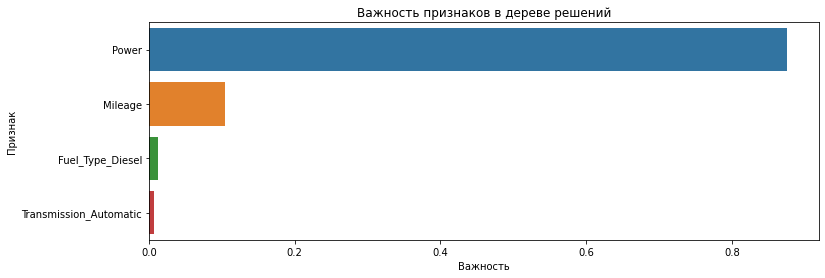

In [23]:
plt.figure(figsize=(12, 4))
sns.barplot(data=importances.sort_values(by='Важность', ascending=False), y='Признак', x='Важность', orient='h', )
plt.title('Важность признаков в дереве решений')
plt.show()

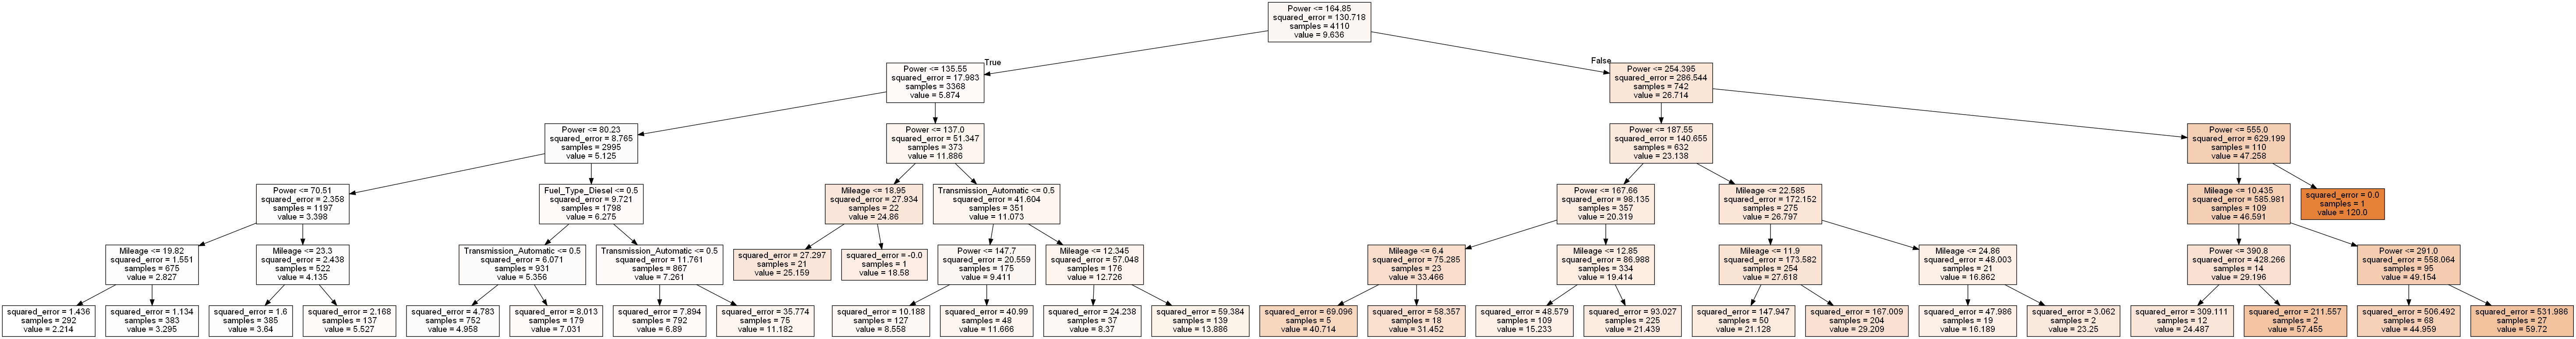

In [37]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

export_graphviz(best_tree, feature_names=best_params.index, filled=True, out_file='tree.dot')
!dot -Tpng tree.dot -o tree.png
Image(filename='tree.png')

## Сравнение моделей

In [40]:
print('Линейная регрессия')
print_metrics(y_test, y_pred_linear)

print('\nПолиномиальная регрессия')
print_metrics(y_test, y_pred_poly)

print('\nМетод опорных векторов')
print_metrics(y_test, y_pred_svm)

print('\nДерево решений')
print_metrics(y_test, y_pred_tree)

Линейная регрессия
R^2: 0.6306198683102151
MSE: 43.12456708118208
MAE: 3.983550649759265

Полиномиальная регрессия
R^2: 0.697571303238948
MSE: 35.30808915217877
MAE: 3.296718915236735

Метод опорных векторов
R^2: 0.6035140496266517
MSE: 46.2891300769292
MAE: 3.7213021301959976

Дерево решений
R^2: 0.691540870508795
MSE: 36.012132977195456
MAE: 2.5113584837999228
